In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.layers import Conv2D,Input,LeakyReLU,Dense,Activation,Flatten,Dropout,MaxPool2D
from keras import models
#from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import keras.optimizers   
import time
from keras.optimizer_v2  import adam,rmsprop  #不同版本的keras
import tensorflow as tf
import platform 

print("python版本："+platform.python_version())
print("keras版本"+keras.__version__)
print(tf.__version__)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
python版本：3.9.2
keras版本2.5.0
2.5.0-rc0


数据预处理

In [2]:
np.random.seed(520)
io="D:\\_dataset\\rock_label_1.csv"
data = pd.read_csv(io,encoding='GBK')
alist=data.values[0::,1]
labellist={'浅灰色细砂岩':0, '深灰色粉砂质泥岩':1, '黑色煤':2, '灰色泥质粉砂岩':3, '灰色细砂岩':4, '深灰色泥岩':5, '灰黑色泥岩':6}
#7分类

亮度归一化

In [3]:
#亮度归一化
def Liangduguiyi(image):
    m_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    Gamma = np.log(128.0 / 255.0) / np.log(cv2.mean(m_gray)[0] / 255.0)
    lookUpTable = np.empty((1, 256), np.uint8)
    for i in range(256):
        lookUpTable[0, i] = np.clip(pow(i / 255.0, Gamma) * 255.0, 0, 255)
    image = cv2.LUT(image, lookUpTable)
    return image

In [4]:
r_width,r_height=112,112

rock_sample_data='D:\_dataset\Data_all'
files = os.listdir(rock_sample_data)
images=[]
images_norm=[]
label=[]
count=[0,0,0,0,0,0,0]
number=0
for img in files:     
    full_path=rock_sample_data+"/"+img
    #img = Liangduguiyi(cv2.imread(full_path))   #亮度归一化
    img = cv2.imread(full_path)
    #img = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)   #单通道
    #img=cv2.normalize(img,dst=None,alpha=350,beta=10,norm_type=cv2.NORM_MINMAX)   #预处理，增强图像对比度
    #images.append(cv2.cvtColor(cv2.resize(img,(r_width,r_height),interpolation=cv2.INTER_NEAREST),cv2.COLOR_GRAY2BGR))#三通道，缩小图片到112*112
    images.append(cv2.resize(img,(r_width,r_height),interpolation=cv2.INTER_NEAREST))   #缩小图片到r_width*r_height
    i=eval(full_path[-5])
    label.append(i)
    count[i]+=1
    number+=1
   

In [5]:
X=np.array(images)/255   #对数据除以255，cnn模型对数值小的数处理得比较好
X=X.astype(np.float64)   #转换数据格式,图像格式为np.uint8, 转换成float型，计算机可以计算
Y=np.array(label)
from keras.utils.np_utils import to_categorical  #2.5.0版本的得换成这个...
#from keras import utils 
#Y=to_categorical(Y,7)   #多分类问题得在打乱数据前对Y进行one-hot化

整理，打乱数据集；分离到训练集和测试机

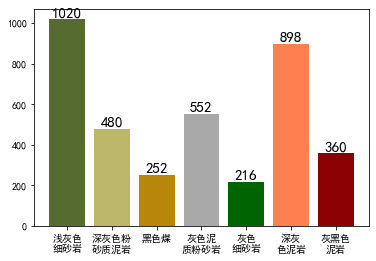

In [6]:
from pylab import *
from matplotlib.font_manager import FontProperties 

def cnt_label(label):
    count=[0,0,0,0,0,0,0]
    for i in range(len(label)):
        count[label[i]]+=1
    return count    
    


def print_count(count):
    mpl.rcParams['font.sans-serif'] = ['SimHei']
    labellist={'浅灰色细砂岩':0, '深灰色粉砂质泥岩':1, '黑色煤':2, '灰色泥质粉砂岩':3, '灰色细砂岩':4, '深灰色泥岩':5, '灰黑色泥岩':6}
    name=['浅灰色\n细砂岩', '深灰色粉\n砂质泥岩', '黑色煤', '灰色泥\n质粉砂岩', '灰色\n细砂岩', '深灰\n色泥岩', '灰黑色\n泥岩']
    rects=plt.bar(range(len(count)),count,tick_label=name,color=['darkolivegreen','darkkhaki','darkgoldenrod','darkgray','darkgreen','coral','darkred'])
    for rect in rects:  #rects 是三根柱子的集合
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=15, ha='center', va='bottom')

    plt.show() 
    
print_count(count)

In [7]:
num_example = len(images)
print("数量:")
print(num_example)
arr=[]

dir_dataset_file="D:\\_dataset\trained_models\dataset_file.txt"
if os.path.exists(dir_dataset_file)==True:  #读取数据集文件   
    with open(dir_dataset_file) as lines:
        for line in lines:
            arr.append(eval(line))
    print("已读取文件上的模型")
else:
    arr = np.arange(num_example)   #数据集文件不存在，创建数据集并打乱
    np.random.shuffle(arr)# 调用函数，打乱顺序
    
    

dat=X[arr]
data_label=Y[arr]
ratio = 0.8
s = np.int(num_example * ratio)
ss = np.int(num_example *  (ratio+0.1))
x_val = dat[s:ss]
y_val = data_label[s:ss]
x_test = dat[ss:]
y_test = data_label[ss:]

#print(data_label)
print(X.shape)
print(Y.shape)



数量:
3778
(3778, 112, 112, 3)
(3778,)


In [8]:
print(y_test)

[5 5 3 6 3 0 1 4 0 4 5 5 0 0 5 0 3 3 2 1 5 5 5 0 0 0 5 3 3 3 0 2 1 0 6 5 1
 1 0 0 5 5 0 0 0 3 1 1 0 0 0 1 0 0 3 0 3 1 2 0 5 2 6 0 5 3 5 1 0 4 5 0 4 5
 0 1 0 4 3 0 0 1 1 0 5 5 1 0 3 3 2 6 0 0 5 3 0 5 1 0 2 0 0 1 1 5 0 5 5 0 0
 5 6 4 3 5 2 0 1 0 3 0 1 4 5 5 1 5 0 5 6 5 0 4 3 0 6 0 4 0 5 6 6 5 0 5 3 1
 0 1 0 1 1 2 0 0 3 5 0 1 3 5 1 0 3 0 3 0 1 3 3 0 3 3 1 5 1 2 6 1 0 5 5 0 0
 0 0 0 4 0 0 1 0 5 1 1 0 6 5 5 0 6 3 5 2 6 0 2 5 0 6 0 0 5 5 0 5 3 0 5 0 5
 5 1 4 0 0 0 5 5 2 6 0 5 5 1 3 5 3 0 1 5 0 5 0 0 0 5 1 5 1 5 2 0 5 1 2 2 1
 0 5 5 3 4 0 0 0 1 0 0 1 4 0 3 0 0 1 6 2 5 0 0 5 0 3 1 0 3 2 4 0 5 0 3 2 0
 4 5 1 3 0 2 5 5 4 2 1 0 6 3 3 0 3 4 0 1 1 5 4 5 0 1 5 0 6 0 5 3 3 5 5 0 5
 6 5 2 6 6 0 3 0 1 5 5 1 0 0 5 0 5 3 0 4 0 5 0 5 3 1 5 4 3 5 2 5 3 0 6 5 2
 5 0 4 0 5 0 2 0]


In [9]:
y_test=to_categorical(y_test,7)   #多分类问题得在打乱数据前对Y进行one-hot化
print(type(y_test))


<class 'numpy.ndarray'>


In [10]:
print(x_test.shape)
print("矩阵总大小:")
print(len(x_test)*len(x_test[0])*len(x_test[0][0])*len(x_test[0][0][0]))


(378, 112, 112, 3)
矩阵总大小:
14224896


随机访问一个数据并绘图，查看数据处理结果

下图显示的是：深灰色粉砂质泥岩
<class 'numpy.ndarray'>
1


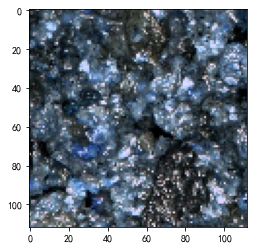

In [11]:
labellist_=['浅灰色细砂岩', '深灰色粉砂质泥岩', '黑色煤', '灰色泥质粉砂岩', '灰色细砂岩', '深灰色泥岩', '灰黑色泥岩']
#print(len(x_train))
import matplotlib.pyplot as plt
import random
rand=random.randint(0,len(X))

imagedemo = X[rand]
imagedemolabel = label[rand]
plt.imshow(imagedemo)
print("下图显示的是："+labellist_[imagedemolabel])
print(type(imagedemo))
print(imagedemolabel)


In [12]:
'''
arr2=[]
with open(dir_dataset_file) as lines:
    for line in lines:
        arr2.append(eval(line))
        
#print((arr2==arr).all())'''

'\narr2=[]\nwith open(dir_dataset_file) as lines:\n    for line in lines:\n        arr2.append(eval(line))\n        \n#print((arr2==arr).all())'

下面是集成学习代码  
1.读取模型

In [13]:
from keras.models import load_model
dir_model=[]
dir_model_base='D:\\_dataset\\trained_models\\'
dir_model.append(dir_model_base+"原始模型(softmax,512epochs).h5")
dir_model.append(dir_model_base+"dense121(256epochs).h5")
dir_model.append(dir_model_base+"densenet169(softmax,256epochs).h5")
dir_model.append(dir_model_base+"VGG16(softmax,256epochs).h5")
#dir_model.append(dir_model_base+"VGG19(softmax,256epochs).h5")

#model1
#model2=define_model()
cnt_models=len(dir_model)
models=[]
for i in range(cnt_models):
    models.append(load_model(dir_model[i]))
print("已读取{}个模型".format(cnt_models))

已读取4个模型


In [14]:
#model1=load_model(dir_model[1])
#print(x_test)

2.进行模型预测

In [15]:

pre=[]
for i in range(cnt_models):
    #pre.append(to_categorical(np.argmax(models[i].predict(x_test), axis=-1),7))  #投票法
    pre.append(models[i].predict(x_test))  #概率上的投票法...
    #print(to_categorical(np.argmax(models[i].predict(x_test), axis=-1),7))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmps57lcv21.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmps57lcv21.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [16]:
#测试集
cnt_test=cnt_label(np.argmax(y_test, axis=-1))
print(len(pre[0])==len(y_test))
y_test_1=np.argmax(y_test, axis=-1)
print(y_test_1) 
#print(pre)

True
[5 5 3 6 3 0 1 4 0 4 5 5 0 0 5 0 3 3 2 1 5 5 5 0 0 0 5 3 3 3 0 2 1 0 6 5 1
 1 0 0 5 5 0 0 0 3 1 1 0 0 0 1 0 0 3 0 3 1 2 0 5 2 6 0 5 3 5 1 0 4 5 0 4 5
 0 1 0 4 3 0 0 1 1 0 5 5 1 0 3 3 2 6 0 0 5 3 0 5 1 0 2 0 0 1 1 5 0 5 5 0 0
 5 6 4 3 5 2 0 1 0 3 0 1 4 5 5 1 5 0 5 6 5 0 4 3 0 6 0 4 0 5 6 6 5 0 5 3 1
 0 1 0 1 1 2 0 0 3 5 0 1 3 5 1 0 3 0 3 0 1 3 3 0 3 3 1 5 1 2 6 1 0 5 5 0 0
 0 0 0 4 0 0 1 0 5 1 1 0 6 5 5 0 6 3 5 2 6 0 2 5 0 6 0 0 5 5 0 5 3 0 5 0 5
 5 1 4 0 0 0 5 5 2 6 0 5 5 1 3 5 3 0 1 5 0 5 0 0 0 5 1 5 1 5 2 0 5 1 2 2 1
 0 5 5 3 4 0 0 0 1 0 0 1 4 0 3 0 0 1 6 2 5 0 0 5 0 3 1 0 3 2 4 0 5 0 3 2 0
 4 5 1 3 0 2 5 5 4 2 1 0 6 3 3 0 3 4 0 1 1 5 4 5 0 1 5 0 6 0 5 3 3 5 5 0 5
 6 5 2 6 6 0 3 0 1 5 5 1 0 0 5 0 5 3 0 4 0 5 0 5 3 1 5 4 3 5 2 5 3 0 6 5 2
 5 0 4 0 5 0 2 0]


3.集成学习

In [17]:
#投票法，计算每个模型的预测值之和
if cnt_models>2:
    all_pre=np.sum(pre,axis=0)          #对应位置的概率叠加
    all_pre_spread=all_pre/cnt_models    #取均值后，集成学习后预测概率的分布
    all_pre=np.argmax(all_pre_spread, axis=-1)    #取概率最大对应的标签
else:
    all_pre_spread=np.sum(pre,axis=0)/cnt_models
    all_pre=np.argmax(all_pre_spread, axis=-1)  #如果只有两个模型，那么用预测的概率相加

print(all_pre)


[5 5 6 6 5 1 1 4 0 4 5 5 0 0 5 0 0 0 2 5 5 5 5 0 5 0 5 0 0 1 0 2 1 0 6 5 1
 1 0 0 5 5 0 0 0 0 1 1 0 0 0 5 1 0 5 0 5 0 2 0 5 2 6 0 5 5 5 1 0 3 5 0 4 5
 0 5 5 4 3 0 0 5 3 5 5 5 1 0 0 3 2 3 0 0 5 3 0 5 1 0 2 0 0 1 1 5 0 5 5 0 0
 5 5 1 5 5 2 0 5 0 5 0 5 4 5 5 1 5 0 5 6 5 0 4 3 0 5 0 4 0 0 6 6 5 0 3 6 1
 0 1 0 1 1 2 0 0 5 5 0 3 3 5 5 0 5 0 0 0 0 0 5 0 5 3 1 5 1 2 6 1 0 5 5 0 0
 0 5 6 4 0 0 1 0 5 0 0 0 6 0 5 0 6 3 5 2 5 0 2 5 0 6 0 0 5 5 0 5 5 0 5 0 0
 6 5 1 0 5 5 0 5 2 5 5 5 5 1 3 5 5 0 4 5 0 5 0 0 0 5 1 5 1 5 2 0 5 1 2 2 1
 0 5 5 3 1 0 0 0 1 0 0 5 4 0 3 0 0 1 6 2 5 5 0 5 0 3 1 0 6 2 4 0 5 0 3 2 0
 4 5 3 3 0 2 5 5 1 2 3 0 6 5 1 0 3 1 0 1 5 5 3 5 0 1 5 0 6 0 5 5 5 5 5 0 5
 6 5 2 6 6 0 5 0 5 5 5 1 0 0 5 0 5 5 0 4 0 5 0 0 3 4 5 4 3 5 2 5 5 5 6 5 2
 5 0 4 5 0 5 2 0]


In [18]:

#print(sum(all_pre_spread[0]))
#print(all_pre_spread[0])

print(len(y_test))
print("原始模型(softmax,512epochs):一个样本的预测值之和："+str(sum(pre[0][5])))
print("dense121(256epochs):一个样本的预测值之和："+str(sum(pre[1][5])))
print("densenet169(softmax,256epochs):一个样本的预测值之和："+str(sum(pre[2][5])))
print("VGG16(softmax,256epochs):一个样本的预测值之和："+str(sum(pre[3][5])))



378
原始模型(softmax,512epochs):一个样本的预测值之和：1.0
dense121(256epochs):一个样本的预测值之和：1.0
densenet169(softmax,256epochs):一个样本的预测值之和：1.0
VGG16(softmax,256epochs):一个样本的预测值之和：0.99999994


[109, 31, 24, 16, 14, 81, 17]
[0.8861788617886179, 0.5961538461538461, 1.0, 0.3404255319148936, 0.6666666666666666, 0.9101123595505618, 0.7727272727272727]


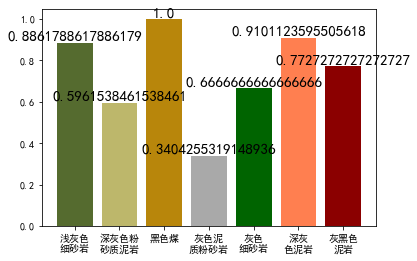

集成学习后的测试集准确率：0.7724867724867724
集成学习后的损失（交叉熵）：0.7078404502263145


In [146]:

'''
y_test_1=np.argmax(y_val, axis=-1)
print(y_test_1)
'''




def draw_test_acc(pre,y_test,cnt_test):
    pre_cnt=[0,0,0,0,0,0,0]  #每个类别预测准确率
    for i in range(len(pre)):
        if pre[i]==y_test[i]:
            pre_cnt[pre[i]]+=1
    print(pre_cnt)
    acc=str(sum(pre_cnt)/sum(cnt_test))
    for i in range(len(pre_cnt)):        
        pre_cnt[i]=pre_cnt[i]/cnt_test[i]
    print(pre_cnt)
    print_count(pre_cnt)
    return acc

acc_count=draw_test_acc(all_pre,y_test_1,cnt_test)

from keras import losses
print("集成学习后的测试集准确率："+str(acc_count))
keras_loss=sum(losses.categorical_crossentropy(y_test,all_pre_spread))/len(y_test_1)      #all_pre_spread
print("集成学习后的损失（交叉熵）："+str(keras_loss))

In [147]:

print('\nTesting -------------')

eval_list=[]
for i in range(len(models)):
    eval_list.append(models[i].evaluate(x_test,y_test))



Testing -------------
12/12 [==============================] - 2s 42ms/step - loss: 0.9981 - accuracy: 0.6429


In [148]:
print(eval_list)

[[0.8742552995681763, 0.7433862686157227], [0.9345741868019104, 0.6719576716423035], [0.9891175031661987, 0.6455026268959045], [0.9981478452682495, 0.6428571343421936]]


各个模型的测试

[99, 19, 20, 13, 15, 63, 14]
[0.8048780487804879, 0.36538461538461536, 0.8333333333333334, 0.2765957446808511, 0.7142857142857143, 0.7078651685393258, 0.6363636363636364]


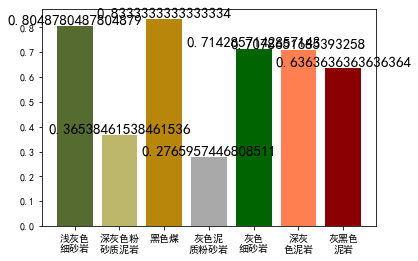

该模型的测试集准确率：0.6428571428571429


In [154]:
pre_1=np.argmax(models[3].predict(x_test), axis=-1)
#model.predict_classes(x_test)   
acc=draw_test_acc(pre_1,y_test_1,cnt_test)
print("该模型的测试集准确率："+str(acc))

[99, 29, 19, 7, 16, 68, 16]
[0.8048780487804879, 0.5576923076923077, 0.7916666666666666, 0.14893617021276595, 0.7619047619047619, 0.7640449438202247, 0.7272727272727273]


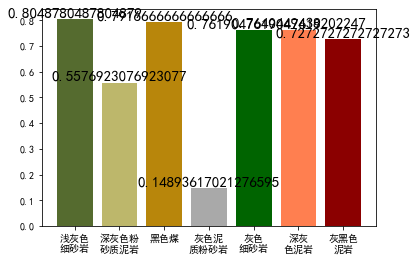

该模型的测试集准确率：0.671957671957672


In [157]:
pre_2=np.argmax(models[1].predict(x_test), axis=-1)
#model.predict_classes(x_test)   
acc=draw_test_acc(pre_2,y_test_1,cnt_test)
print("该模型的测试集准确率："+str(acc))

In [151]:
#分别几个模型和集成后的准确率以及损失
acc_list=[eval("%.4f"%(eval(acc_count)))]
loss_list=[eval("%.4f"%(keras_loss))]
for i in range(len(models)):
    loss_list.append(eval("%.4f"%(sum(losses.categorical_crossentropy(y_test,pre[i]))/len(y_test_1))))      #交叉熵损失函数
    acc_list.append(eval("%.4f"%(eval_list[i][1])))
print(acc_list) 
print(loss_list)

[0.7725, 0.7434, 0.672, 0.6455, 0.6429]
[0.7078, 0.8743, 0.9346, 0.9891, 0.9981]


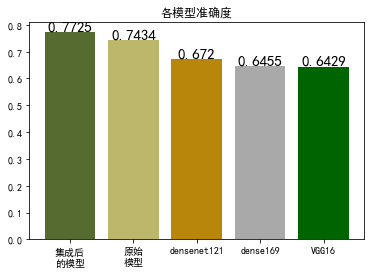

In [152]:
'''
acc_list=[acc,list1[1],list2[1],list3[1]]
loss_list=[]
'''

acc_label=["集成后\n的模型",'原始\n模型','densenet121','dense169','VGG16']
loss_label=acc_label
mpl.rcParams['font.sans-serif'] = ['SimHei']
rects=plt.bar(range(len(acc_label)), np.array(acc_list),tick_label=acc_label,
              color=['darkolivegreen','darkkhaki','darkgoldenrod','darkgray','darkgreen','coral'])
for rect in rects:  
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=15, ha='center', va='bottom')
plt.title('各模型准确度')
plt.show() 

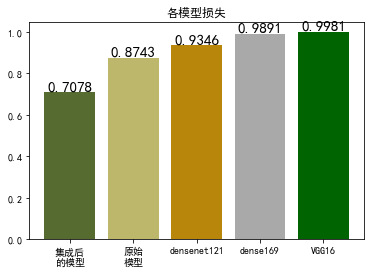

In [153]:
rects=plt.bar(range(len(loss_label)),loss_list,tick_label=loss_label,color=['darkolivegreen','darkkhaki','darkgoldenrod','darkgray','darkgreen','coral'])
for rect in rects:  
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=15, ha='center', va='bottom')
plt.title('各模型损失')
plt.show() 